<center>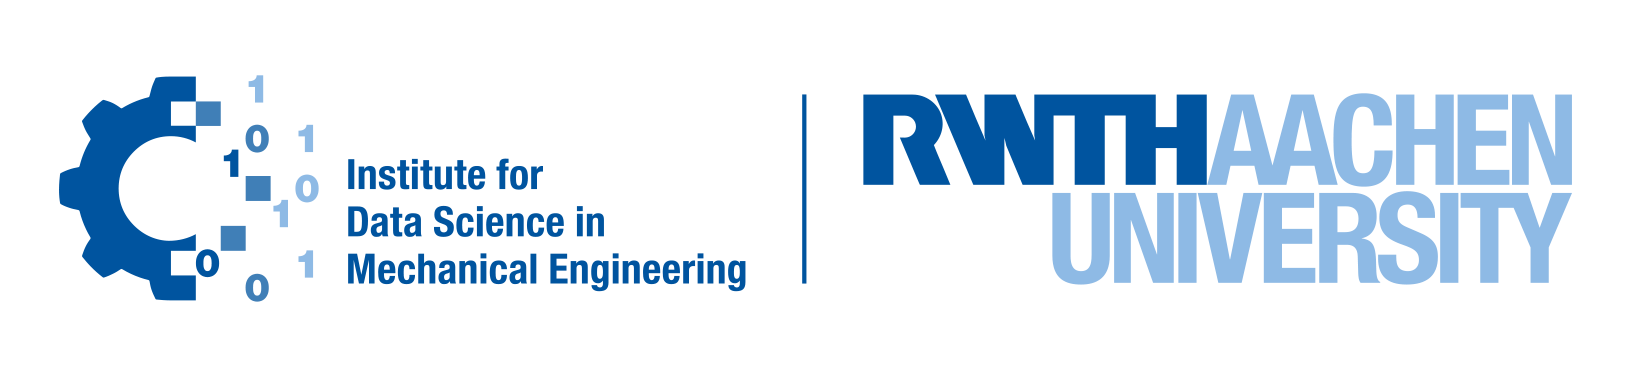</center>

**MOOC Learning-based Control** <br> 
RWTH Aachen University, DSME (Prof. Sebastian Trimpe, Paul Brunzema) <br>

---

# Swing-up of the Cart Pole using Model Predictive Control

In this notebook, we will implement a toy-MPC for the cart pole swing-up.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from scipy.optimize import minimize
import time

# Set random seeds for reproducibility
np.random.seed(42)

## The Cart Pole System

<center>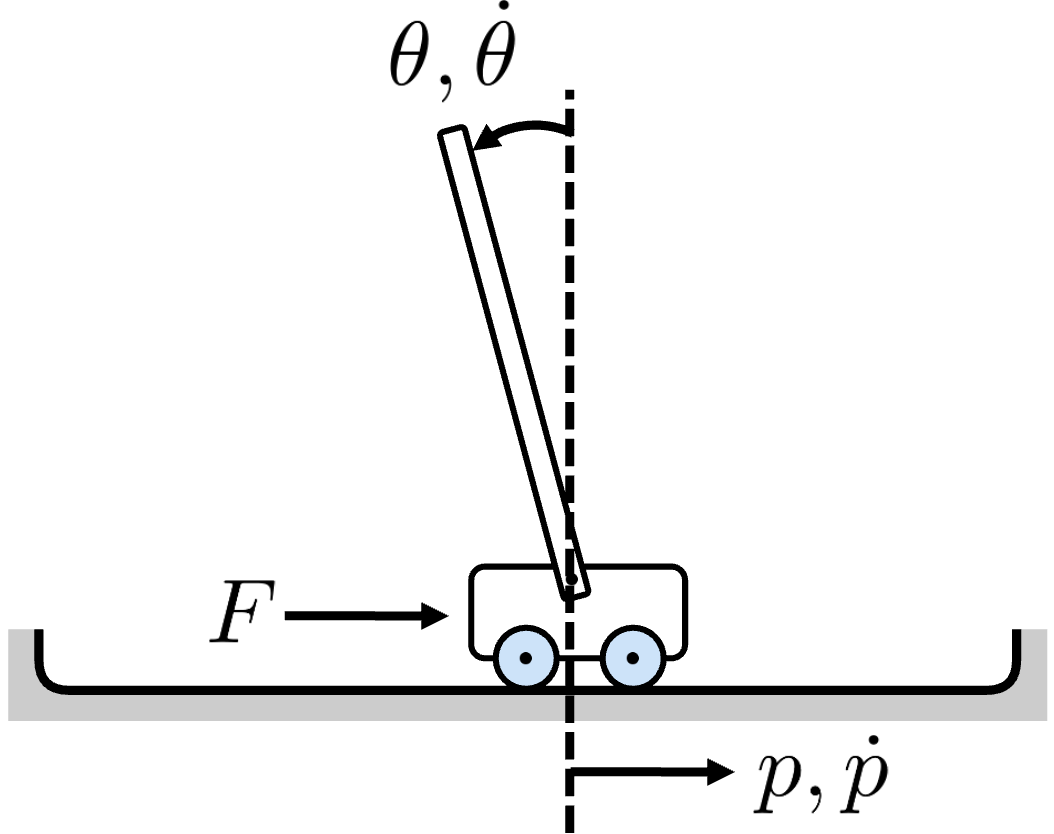</center>

A classic benchmark system in control and reinforcement learning

**States**

- position of the cart $p$
- angle of the pole $\theta$
- velocity of the cart $\dot p$ 
- angular velocity of the pole $\dot\theta$

**Input**

- Force applied to the cart $F$

In [2]:
# Example parameters
_DEFAULT_PARAMS = {
    "M": 1.0,  # Mass of cart (kg)
    "m": 0.1,  # Mass of pole (kg)
    "J": 0.01,  # Moment of inertia of pole (kg*m^2)
    "l": 0.5,  # Length to COM of pole (m)
    "c": 0.1,  # Cart friction coefficient
    "gamma": 0.01,  # Pole friction coefficient
    "g": 9.81,  # Gravity (m/s^2)
}


class CartPole:
    """
    Cart-pole system simulation.
    """

    def __init__(self, params=None):
        """
        Initialize the cart-pole system with physical parameters.

        Args:
            params (dict): Parameters of the cart-pole system
        """
        self.params = {
            **_DEFAULT_PARAMS,
            **(params or {}),
        }

    def dynamics(self, t, state, u):
        """
        Compute the dynamics of the cart-pole system.

        Args:
            t (float): Time (not used in this system, but required for compatibility)
            state (numpy.ndarray): State vector [p, theta, dotp, theta_dot]
            u (float): Input force F

        Returns:
            numpy.ndarray: Time derivative of the state vector
        """
        # Extract state variables
        p, theta, p_dot, theta_dot = state

        # Extract parameters
        M = self.params["M"]  # Mass of the base (cart)
        m = self.params["m"]  # Mass of the pole
        J = self.params["J"]  # Moment of inertia of the pole
        l = self.params["l"]  # Distance from base to center of mass
        c = self.params["c"]  # Coefficient of viscous friction for cart
        gamma = self.params["gamma"]  # Coefficient of viscous friction for pole
        g = self.params["g"]  # Gravity acceleration

        # Compute total mass and total inertia
        Mt = M + m
        Jt = J + m * l**2

        # Compute sine and cosine of theta (using shorthand from equations)
        s_theta = np.sin(theta)
        c_theta = np.cos(theta)

        # First two state derivatives (directly from state definition)
        dp = p_dot
        dtheta = theta_dot

        # Third derivative (ddp) - cart acceleration
        numerator_p_ddot = (
            -m * l * s_theta * theta_dot**2
            + m * g * (m * l**2 / Jt) * s_theta * c_theta
            - c * p_dot
            - (gamma / Jt) * m * l * c_theta * theta_dot
            + u
        )
        denominator_p_ddot = Mt - m * (m * l**2 / Jt) * c_theta**2
        dp_dot = numerator_p_ddot / denominator_p_ddot

        # Fourth derivative (ddtheta) - pole angular acceleration
        numerator_theta_ddot = (
            -m * l**2 * s_theta * c_theta * theta_dot**2
            + Mt * g * l * s_theta
            - c * l * c_theta * p_dot
            - gamma * (Mt / m) * theta_dot
            + l * c_theta * u
        )
        denominator_theta_ddot = Jt * (Mt / m) - m * (l * c_theta) ** 2
        dtheta_dot = numerator_theta_ddot / denominator_theta_ddot

        # Combine into the derivative of the state vector
        dx = np.array([dp, dtheta, dp_dot, dtheta_dot])
        return dx

    def rk4_step(self, state, u, dt):
        """
        Single RK4 integration step.
        (https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods)

        Args:
            state: Current state vector
            u: Control input
            dt: Time step

        Returns:
            Next state after one RK4 step
        """
        k1 = self.dynamics(0, state, u)
        k2 = self.dynamics(0, state + dt / 2 * k1, u)
        k3 = self.dynamics(0, state + dt / 2 * k2, u)
        k4 = self.dynamics(0, state + dt * k3, u)

        next_state = state + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        return next_state

    def simulate(
        self,
        initial_state,
        controller=None,
        t_span=(0, 5),
        dt_sim=0.01,
        dt_control=0.02,
    ):
        """
        Simulate the system with a controller.

        Args:
            initial_state (array): Initial state [x, theta, x_dot, theta_dot]
            controller (function): Control law u = f(t, state)
            t_span (tuple): Time span (t_start, t_end)
            dt_sim (float): Simulation time step (for physics)
            dt_control (float): Control update interval (for controller)

        Returns:
            tuple: A tuple containing (time_array, state_array, control_array)
        """
        # Create time array for simulation
        t = np.arange(t_span[0], t_span[1], dt_sim)
        n_steps = len(t)

        # Initialize state and control arrays
        x = np.zeros((4, n_steps))
        u = np.zeros(n_steps)
        x[:, 0] = initial_state

        # Initialize control time and value
        next_control_time = t_span[0]
        current_control = 0.0

        # Simple fixed-step Runge-Kutta 4 integration
        for i in range(n_steps - 1):
            current_time = t[i]

            # Update control only at control frequency
            if current_time >= next_control_time:
                if controller is not None:
                    current_control = controller(current_time, x[:, i])
                else:
                    current_control = 0.0
                next_control_time = current_time + dt_control

            # Store the current control value
            u[i] = current_control

            # RK4 integration step
            x[:, i + 1] = self.rk4_step(x[:, i], u[i], dt_sim)

        # Set the last control value
        u[-1] = current_control

        return t, x, u

### Add a method for a rollout

In [3]:
def predict_trajectory(self, initial_state, control_sequence, dt):
    """
    Predict trajectory given initial state and control sequence using RK4.

    Args:
        initial_state: Starting state [p, theta, p_dot, theta_dot]
        control_sequence: Array of control inputs
        dt: Time step for integration

    Returns:
        Array of predicted states (N+1, 4) where N is length of control sequence
    """
    n_steps = len(control_sequence)
    states = np.zeros((n_steps + 1, 4))
    states[0] = initial_state

    for i in range(n_steps):
        states[i + 1] = self.rk4_step(states[i], control_sequence[i], dt)

    return states


CartPole.predict_trajectory = predict_trajectory

In [4]:
class AbstractController(ABC):
    def __init__(self):
        pass

    @abstractmethod
    def __call__(self, t, state):
        pass

In [5]:
class MPC(AbstractController):
    """
    Model Predictive Controller for cart-pole swing-up with position constraints.
    """

    def __init__(
        self,
        cart_pole,
        prediction_horizon=20,
        control_horizon=10,
        dt=0.05,
        Q=None,
        R=None,
        Qt=None,
        u_max=10.0,
        p_min=None,  # Minimum cart position
        p_max=None,  # Maximum cart position
    ):
        """
        Initialize MPC controller.

        Args:
            cart_pole: CartPole system model
            prediction_horizon: Number of prediction steps
            control_horizon: Number of control steps to optimize
            dt: Time step for MPC prediction
            Q: State cost matrix (4x4)
            R: Control cost matrix (1x1)
            Qf: Terminal cost matrix (4x4)
            u_max: Maximum control input magnitude
            p_min: Minimum allowable cart position
            p_max: Maximum allowable cart position
        """
        super().__init__()
        self.cart_pole = cart_pole
        self.N = prediction_horizon
        self.Nu = control_horizon
        self.dt = dt
        self.u_max = u_max
        self.p_min = p_min
        self.p_max = p_max

        # Default cost matrices
        if Q is None:
            # Higher weight on angle for swing-up
            self.Q = np.diag([1.0, 10.0, 0.1, 0.1])  # [pos, angle, vel, ang_vel]
        else:
            self.Q = Q

        if R is None:
            self.R = np.array([[0.1]])  # Control effort penalty
        else:
            self.R = R

        if Qt is None:
            self.Qt = 10 * self.Q  # Higher terminal cost
        else:
            self.Qt = Qt

        # Target state (upright position)
        self.x_target = np.array([0.0, 0.0, 0.0, 0.0])  # [pos, angle, vel, ang_vel]

        # Initialize control sequence
        self.u_prev = np.zeros(self.Nu)

    def stage_cost(self, state, control):
        """
        Compute stage cost for given state and control.
        """
        # Ensure inputs are numpy arrays
        state = np.asarray(state)
        control = np.asarray(control)

        # Handle scalar control input
        if control.ndim == 0:
            control = np.array([control])

        # Normalize angle to [-pi, pi] for cost calculation
        state_error = state - self.x_target
        state_error[1] = self.normalize_angle(state_error[1])

        state_cost = state_error.T @ self.Q @ state_error
        control_cost = control.T @ self.R @ control

        return float(state_cost + control_cost)

    def terminal_cost(self, state):
        """
        Compute terminal cost for given state.
        """
        # Ensure input is numpy array
        state = np.asarray(state)

        state_error = state - self.x_target
        state_error[1] = self.normalize_angle(state_error[1])

        return float(state_error.T @ self.Qt @ state_error)

    def normalize_angle(self, angle):
        """
        Normalize angle to [-pi, pi].
        """
        return ((angle + np.pi) % (2 * np.pi)) - np.pi

    def cost_function(self, u_sequence, initial_state):
        """
        Total cost function for optimization.

        Args:
            u_sequence: Control sequence to optimize (Nu,)
            initial_state: Current state

        Returns:
            Total cost
        """
        try:
            # Ensure inputs are proper numpy arrays
            u_sequence = np.asarray(u_sequence)
            initial_state = np.asarray(initial_state)

            # Handle scalar input case
            if u_sequence.ndim == 0:
                u_sequence = np.array([u_sequence])

            # Extend control sequence for prediction horizon
            u_full = np.zeros(self.N)
            u_full[: min(len(u_sequence), self.Nu)] = u_sequence[
                : min(len(u_sequence), self.Nu)
            ]

            # Hold last control value for remaining steps
            if len(u_sequence) < self.N:
                if len(u_sequence) > 0:
                    u_full[len(u_sequence) :] = u_sequence[-1]

            # Predict trajectory using RK4
            states = self.cart_pole.predict_trajectory(initial_state, u_full, self.dt)

            # Compute total cost
            total_cost = 0.0

            # Stage costs
            for i in range(self.N):
                total_cost += self.stage_cost(states[i], u_full[i])

            # Terminal cost
            total_cost += self.terminal_cost(states[-1])

            return float(total_cost)

        except Exception as e:
            print(f"Error in cost function: {e}")
            return 1e6  # Return large penalty for invalid states

    def __call__(self, t, state):
        """
        Compute optimal control input using MPC.

        Args:
            t: Current time
            state: Current state

        Returns:
            Optimal control input
        """
        # Ensure state is numpy array
        state = np.asarray(state)

        # Set up optimization problem
        bounds = [(-self.u_max, self.u_max) for _ in range(self.Nu)]

        if self.p_min is not None or self.p_max is not None:
            # transform to large value if None
            if self.p_min is None:
                self.p_min = -1000
            if self.p_max is None:
                self.p_max = 1000

            margin = 0.02  # Margin for numerical stability

            # Position constraints
            def position_constraints(u_sequence):
                # Predict the trajectory
                states = self.cart_pole.predict_trajectory(state, u_sequence, self.dt)
                # Extract positions
                positions = states[:, 0]
                # Constraints: p_min <= p <= p_max
                c1 = positions - self.p_min - margin  # Should be >= 0
                c2 = self.p_max - positions + margin  # Should be >= 0
                return np.concatenate((c1, c2))

            constraints = {"type": "ineq", "fun": position_constraints}
        else:
            # No position constraints
            constraints = []

        # Use previous solution as initial guess (warm start)
        u0 = self.u_prev.copy()

        # Solve optimization problem
        try:
            result = minimize(
                fun=lambda u: self.cost_function(u, state),
                x0=u0,
                method="SLSQP",
                bounds=bounds,
                constraints=constraints,
                options={"maxiter": 1000, "ftol": 1e-4},
            )

            if result.success:
                optimal_u = result.x
            else:
                print(f"MPC optimization failed: {result.message}")
                optimal_u = u0  # Use previous solution

        except Exception as e:
            print(f"MPC optimization error: {e}")
            optimal_u = u0

        # Update previous solution for next iteration (shift + append)
        if len(optimal_u) >= 2:
            self.u_prev[:-1] = optimal_u[1:]
            self.u_prev[-1] = optimal_u[-1]
        else:
            self.u_prev[:] = optimal_u[0] if len(optimal_u) > 0 else 0.0

        return float(optimal_u[0]) if len(optimal_u) > 0 else 0.0

Running MPC simulation...


/home/bf863194/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


MPC simulation completed in 2.04 seconds


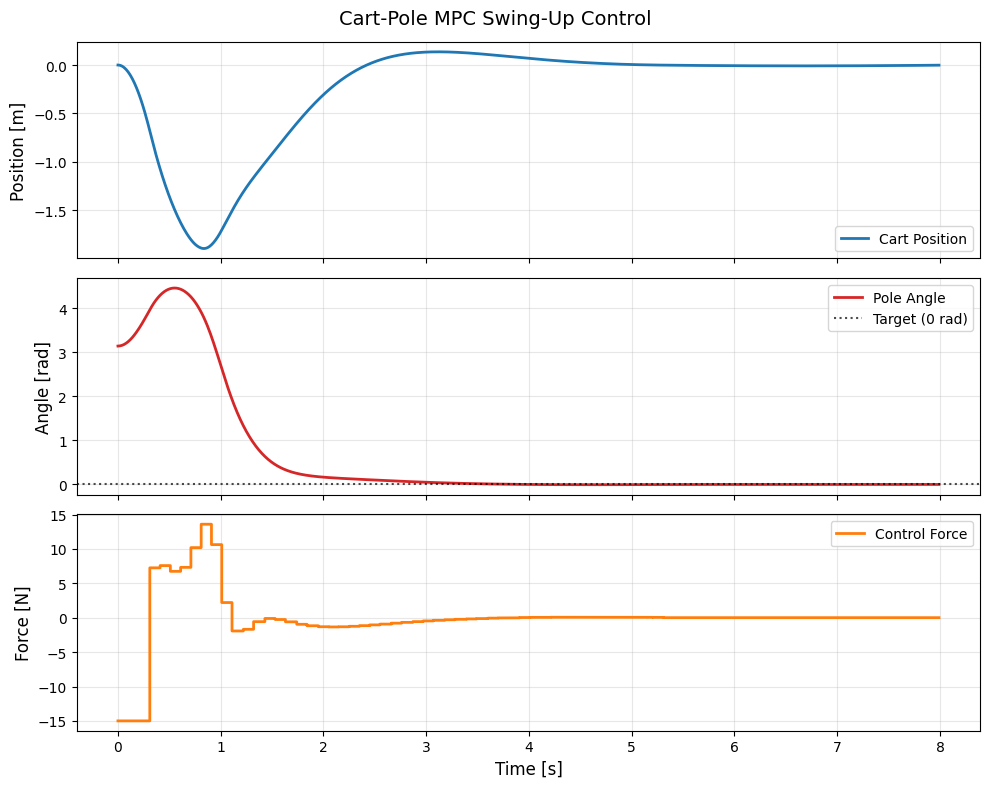

In [6]:
# Initialize cart-pole system
cart_pole = CartPole()

# Initial state (pole hanging down)
initial_state = np.array([0.0, np.pi, 0.0, 0.0])  # [pos, angle, vel, ang_vel]
t_span = (0, 8)

# Run MPC simulation
print("Running MPC simulation...")
mpc_controller = MPC(
    cart_pole,
    prediction_horizon=15,
    control_horizon=8,
    dt=0.1,
    u_max=15.0,
)

start_time = time.time()
t_mpc, x_mpc, u_mpc = cart_pole.simulate(
    initial_state, controller=mpc_controller, t_span=t_span, dt_control=0.1
)
mpc_time = time.time() - start_time
print(f"MPC simulation completed in {mpc_time:.2f} seconds")


def plot_trajectories(time, states, controls, title="Trajectories"):
    """Plot system trajectories."""
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(title, fontsize=14)

    # Position and angle
    axes[0].plot(
        time,
        states[0, :],
        "-",
        label="Cart Position",
        linewidth=2,
        color="tab:blue",
    )
    axes[0].set_ylabel("Position [m]", fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(
        time,
        states[1, :],
        "-",
        label="Pole Angle",
        linewidth=2,
        color="tab:red",
    )
    axes[1].axhline(
        y=0.0,
        color="k",
        linestyle=":",
        alpha=0.7,
        label="Target (0 rad)",
    )
    axes[1].set_ylabel("Angle [rad]", fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Control input
    axes[2].step(
        time,
        controls,
        "-",
        label="Control Force",
        linewidth=2,
        color="tab:orange",
        where="post",
    )
    axes[2].set_ylabel("Force [N]", fontsize=12)
    axes[2].set_xlabel("Time [s]", fontsize=12)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Plot results
plot_trajectories(t_mpc, x_mpc, u_mpc, "Cart-Pole MPC Swing-Up Control")


## Swing up with position constraints


In [7]:
constraints = (-0.9, 0.9)  # Position constraints for cart
position_constrained_mpc_controller = MPC(
    cart_pole,
    prediction_horizon=15,
    control_horizon=8,
    dt=0.1,
    u_max=15.0,
    p_min=constraints[0],  # Position constraint
    p_max=constraints[1],  # Position constraint
)

t_cmpc, x_cmpc, u_cmpc = cart_pole.simulate(
    initial_state,
    controller=position_constrained_mpc_controller,
    t_span=t_span,
    dt_control=0.1,
)

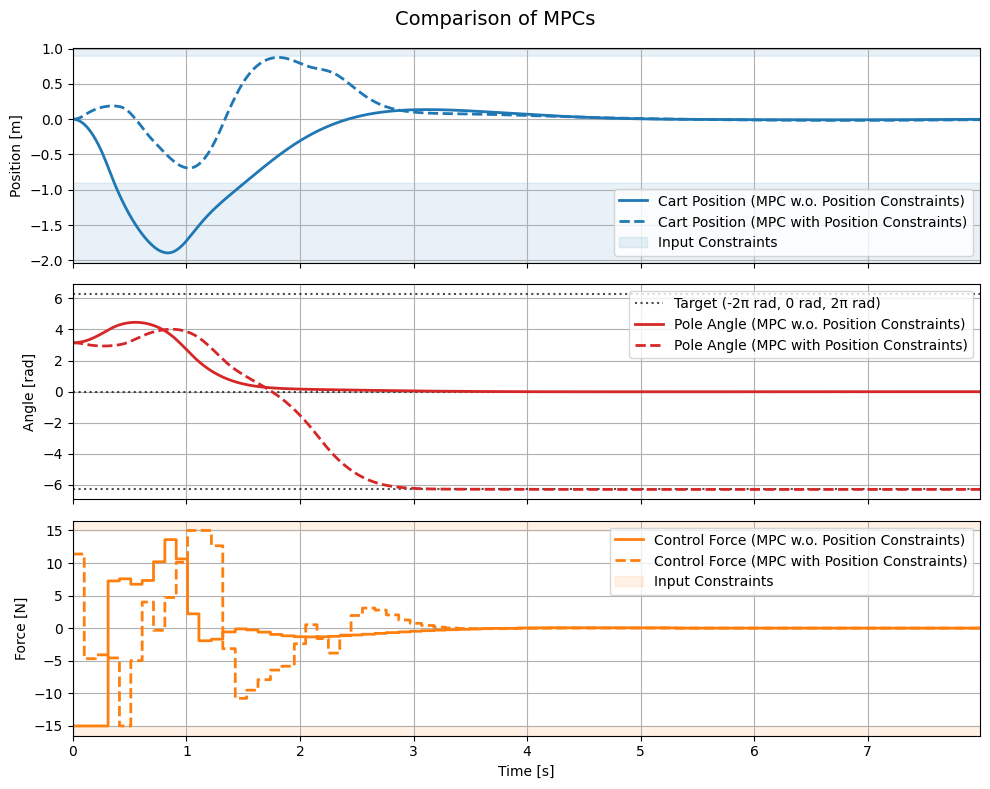

In [8]:
def compare_controllers(ts, xs, us, labels):
    """Compare trajectories of different controllers."""
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    fig.suptitle("Comparison of MPCs", fontsize=14)

    axes[1].axhline(
        y=0.0,
        color="k",
        linestyle=":",
        alpha=0.7,
        label="Target (-2π rad, 0 rad, 2π rad)",
    )
    axes[1].axhline(
        y=2 * np.pi,
        color="k",
        linestyle=":",
        alpha=0.7,
    )
    axes[1].axhline(
        y=-2 * np.pi,
        color="k",
        linestyle=":",
        alpha=0.7,
    )

    linestyles = ["-", "--", "=-."]
    for i, (t, x, u, ls, label) in enumerate(zip(ts, xs, us, linestyles, labels)):
        axes[0].plot(
            t,
            x[0, :],
            label=f"Cart Position ({label})",
            color="tab:blue",
            linestyle=ls,
            lw=2,
        )
        axes[1].plot(
            t,
            x[1, :],
            label=f"Pole Angle ({label})",
            color="tab:red",
            linestyle=ls,
            lw=2,
        )
        axes[2].step(
            t,
            u,
            label=f"Control Force ({label})",
            color="tab:orange",
            where="post",
            linestyle=ls,
            lw=2,
        )

    # input constraints
    ymin, ymax = axes[2].get_ylim()
    axes[2].fill_between(
        t,
        mpc_controller.u_max,
        ymax,
        color="tab:orange",
        alpha=0.1,
    )

    axes[2].fill_between(
        t,
        ymin,
        -mpc_controller.u_max,
        color="tab:orange",
        alpha=0.1,
        label="Input Constraints",
    )
    axes[2].set_ylim(ymin, ymax)

    # plot position constraints
    ymin, ymax = axes[0].get_ylim()
    axes[0].fill_between(
        t,
        ymin,
        constraints[0],
        color="tab:blue",
        alpha=0.1,
        label="Input Constraints",
    )
    axes[0].fill_between(
        t,
        constraints[1],
        ymax,
        color="tab:blue",
        alpha=0.1,
    )
    axes[0].set_ylim(ymin, ymax)

    for ax in axes:
        ax.grid(True)
        ax.set_xlim(ts[0][0], ts[0][-1])
        ax.legend()

    axes[0].set_ylabel("Position [m]")
    axes[1].set_ylabel("Angle [rad]")
    axes[2].set_ylabel("Force [N]")
    axes[-1].set_xlabel("Time [s]")
    plt.tight_layout()
    plt.show()


compare_controllers(
    ts=(t_mpc, t_cmpc),
    xs=(x_mpc, x_cmpc),
    us=(u_mpc, u_cmpc),
    labels=(
        "MPC w.o. Position Constraints",
        "MPC with Position Constraints",
    ),
)

---
<center>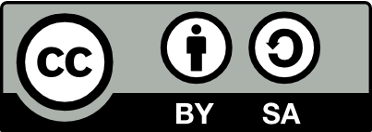</center>

This work was originally created by Sebastian Trimpe and Paul Brunzema. <br> 
It is licensed under Attribution-ShareAlike 4.0 International [(CC-BY-SA 4.0)](https://creativecommons.org/licenses/by-sa/4.0/).